<a href="https://colab.research.google.com/github/Alexandr211/diploma_covid19/blob/main/DiplomaCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Дипломная работа "Определение наличия COVID-19**"

In [ ]:
from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Для отрисовки графиков
from PIL import Image #Для отрисовки изображений
import random #Для генерации случайных чисел 
import math # Для округления
import os #Для работы с файлами 
# подключем диск
from google.colab import drive
#увеличим дефолтный размер графиков
from pylab import rcParams

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Загрузим датасет с Kaggle**

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexandr211","key":"77c0a6f6bec82a9f6356465806911c8c"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Oct 21 08:07 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# List available datasets.
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-10 17:55:57          14066  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8444  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3768  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Women                               838MB  2021-02-28 14:56:00           1633  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [ ]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:22<00:00, 34.3MB/s]
100% 2.06G/2.06G [00:22<00:00, 97.7MB/s]


In [ ]:
#import gdown
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
# gdown.download('https://storage.googleapis.com/datasets_ai/Base/5_Conv/middle_fmr.zip', None, quiet=True)

In [ ]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/chest-xray-covid19-pneumonia.zip' -d '/content/drive/My Drive/diplomaData' 

In [ ]:
img_path = '/content/drive/My Drive/diplomaData/Data/' + 'train/' + 'COVID19/' + 'COVID19(443).jpg'
img_arr = np.asarray(image.load_img(img_path, grayscale=False, target_size=(500, 500)))
#img_arr = np.asarray(image.load_img(img_path, grayscale=False))
img_arr.shape

(500, 500, 3)

**Загрузка и преобразование данных**

In [ ]:
train_path = '/content/drive/My Drive/diplomaData/Data/train' #Папка с папками картинок, рассортированных по категориям
test_path = '/content/drive/My Drive/diplomaData/Data/test'
predict_path = '/content/drive/My Drive/diplomaData/Data/predict'
batch_size = 60 #Размер выборки
img_width = 500 #Ширина изображения
img_height = 500 #Высота изображения
batch_size_validation = 200

In [ ]:
#Генератор изображений
datagenTrain = ImageDataGenerator(
    rescale=1. / 255, #Значения цвета меняем на дробные показания
    rotation_range=0, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.0, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.0, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=False, #Включаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.2 #Указываем разделение изображений на обучающую и тестовую выборку
)
datagenTest = ImageDataGenerator(
    rescale=1. / 255, #Значения цвета меняем на дробные показания
    rotation_range=1, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=False, #Включаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода    
)

In [ ]:
# обучающая выборка
train_generator = datagenTrain.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по типам заболеваний
    shuffle=True, #Перемешивание выборки
    seed=42,
    subset='training' # устанавливаем как набор для обучения    
)

# проверочная выборка
validation_generator = datagenTrain.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по типам заболеваний
    shuffle=True, #Перемешивание выборки
    seed=42,
    subset='validation' # устанавливаем как набор для обучения    
)

Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.


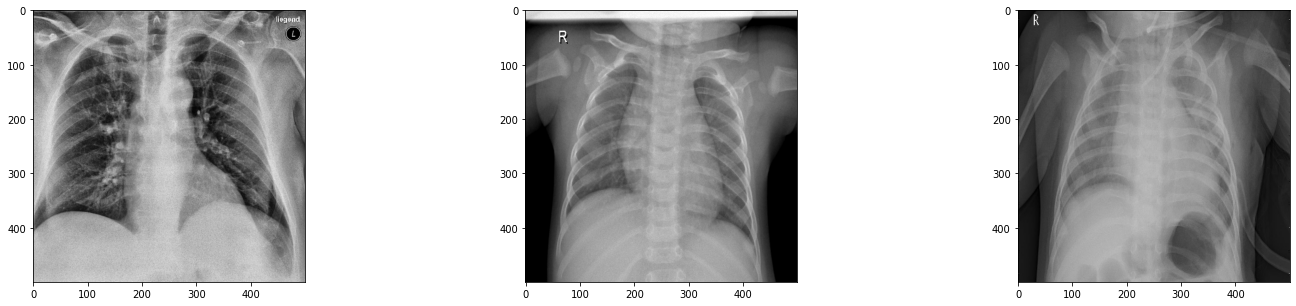

In [ ]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 3, figsize=(25, 5)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем классам
  car_path = train_path + '/' + os.listdir(train_path)[i] + '/'#Формируем путь к выборке
  img_path = car_path + random.choice(os.listdir(car_path)) #Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии

plt.show() #Показываем изображения

**Создаем модель нейронной сети**

In [ ]:
#Создаем последовательную модель
model = Sequential()
model.add(BatchNormalization(input_shape=(img_width, img_height, 3)))
#Первый сверточный слой
#model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
#Второй сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Третий сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.1))
#Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.1))
#Пятый сверточный слой
model.add(Flatten())
#Полносвязный слой
#Полносвязный слой для классификации
#model.add(Dense(512, activation='relu'))
#Слой регуляризации Dropout
#model.add(Dropout(0.25))
#Вызодной полносвязный слой
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 500, 500, 3)       12        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 500, 500, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 166, 166, 64)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 166, 166, 128)     73856     
_________________________________________________________________
dropout_22 (Dropout)         (None, 166, 166, 128)     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 166, 166, 64)      73792     
_________________________________________________________________
dropout_23 (Dropout)         (None, 166, 166, 64)    

**Обучим модель**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=3,
    verbose=1
)

Epoch 1/3
68/68 [==============================] - 453s 6s/step - loss: 0.8025 - accuracy: 0.7850 - val_loss: 0.5361 - val_accuracy: 0.7716
Epoch 2/3
68/68 [==============================] - 491s 7s/step - loss: 0.2376 - accuracy: 0.9154 - val_loss: 0.3732 - val_accuracy: 0.8696
Epoch 3/3
68/68 [==============================] - 487s 7s/step - loss: 0.1794 - accuracy: 0.9401 - val_loss: 0.2450 - val_accuracy: 0.9255


**Сохраним полученную модель**

In [ ]:
model.save('/content/drive/My Drive/diplomaData/diploma.h5')

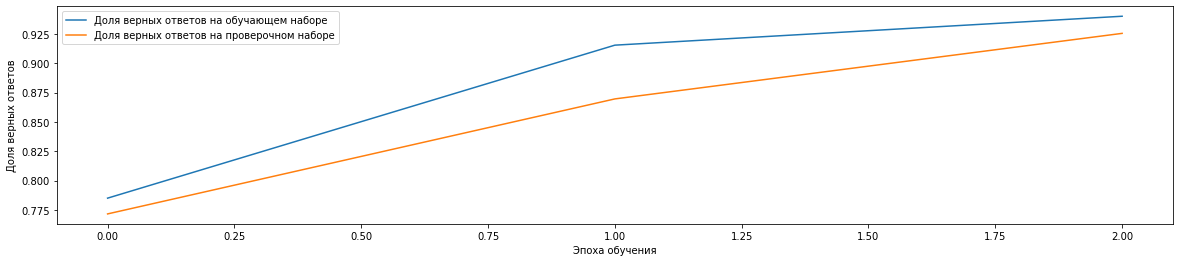

In [ ]:
# увеличим дефолтный размер графиков
rcParams['figure.figsize'] = 20, 4

#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Загрузим модель**

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from io import BytesIO
from PIL import Image 

model = load_model('/content/drive/My Drive/diplomaData/diploma.h5', compile = False)

**Проверим работу модели на тестовой базе**

In [ ]:
rightPrediction = 0
totalCount = 0
fullTestPath = test_path+'/COVID19'
for j in os.listdir(fullTestPath):  
  x_img_arr = []
  totalCount += 1
  pathToImage = fullTestPath+'/'+j  
  x_img_arr.append(np.asarray(image.load_img(pathToImage, grayscale=False, target_size=(img_width, img_width))))
  x_img_arr = np.array(x_img_arr)
  prediction = model.predict(x_img_arr)

  if(np.argmax(prediction[0]) == 0):
    rightPrediction += 1
  
result = 100*rightPrediction/totalCount
print('Правильный результат в тестовом наборе с COVID19:', round(result,2),'%')

rightPrediction = 0
totalCount = 0
FullNormalPath = test_path+'/NORMAL'
for j in os.listdir(FullNormalPath):  
  x_img_arr = []
  totalCount += 1
  pathToImage = FullNormalPath+'/'+j  
  x_img_arr.append(np.asarray(image.load_img(pathToImage, grayscale=False, target_size=(img_width, img_width))))
  x_img_arr = np.array(x_img_arr)
  prediction = model.predict(x_img_arr)

  if(np.argmax(prediction[0]) != 0):
    rightPrediction += 1
  
result = 100*rightPrediction/totalCount
print('Правильный результат в тестовом наборе с NORMAL:', round(result,2),'%')





Правильный результат в тестовом наборе с COVID19: 96.55 %
Правильный результат в тестовом наборе с NORMAL: 98.74 %
